In [1]:
%matplotlib inline

# 1 Baseline

Считываем данные, строим baseline модель и рассматриваем разные метрики и графики для задачи классификации.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


### 1.1 Данные

In [13]:
data = pd.read_csv('binary_project.csv')
data.shape

(24521, 262)

In [14]:
data.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1053371037,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,76507184,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,76753690,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1026167358,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,7220095746,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [15]:
data = data.set_index('ID')

In [16]:
# Разделим признаки и целевую переменную
data_prelim = data.copy()

X = data_prelim.drop('TARGET', axis=1)
y = data_prelim['TARGET']

In [17]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 20%


**У 20% признаков есть прощенные значения**

### 1.2 Разделяем на train и test

0    0.708454
1    0.291546
Name: TARGET, dtype: float64

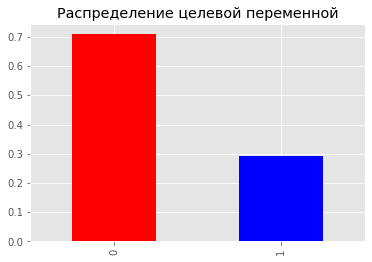

In [20]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной', color = ['r', 'b']);
y.value_counts()/y.shape

In [21]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0    0.709299
1    0.290701
Name: TARGET, dtype: float64

Test
0    0.705921
1    0.294079
Name: TARGET, dtype: float64


### 1.3 Pipeline для baseline модели

Для построения baseline модели будем использовать логистическую регрессию.

In [22]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

В датасете порядка 20% признаков содержат пропущенные значения. Т.к. логистическая регрессия не умеет обрабатывать пропущенные значения, мы должны заполнить их сами. Для этого воспользуемся классом sklearn.impute.SimpleImputer. У этого класса есть параметр strategy, который определяет способ заполнения пропусков. Он может принимать несколько значений.

In [23]:
from sklearn.impute import SimpleImputer

In [24]:
SimpleImputer()

SimpleImputer()

Для baseline модели выставим параметр strategy в значение mean.

In [27]:
step_imputer = ("imputer", SimpleImputer(strategy="mean"))

Базовый пайплайн будет состоять только из двух шагов:
- Заполнение пропусков средним
- Логистическая регрессия с базовыми параметрами

In [28]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_imputer,
    step_log_reg
])

### 1.4 Кросс-валидация

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Варианты:
- ‘precision’, ‘recall’, ‘accuracy’, ‘f1’
- ‘average_precision’, ‘roc_auc’

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [32]:
%%time
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline: roc_auc = 0.64 (+/- 0.01)
CPU times: user 24.6 ms, sys: 27.5 ms, total: 52.1 ms
Wall time: 1.81 s


/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

### 1.5 Графики и метрики baseline модели на тесте

In [33]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
bl_y_pred

array([0.15063608, 0.15634581, 0.5030767 , ..., 0.16888887, 0.42362266,
       0.38825509])

In [41]:
y_test.astype(bool)

ID
58198991      False
437075004     False
345260526      True
749150565     False
732888674      True
              ...  
46621619      False
638336816     False
1153011751     True
5387687654    False
526067674     False
Name: TARGET, Length: 6131, dtype: bool

#### Распределение предсказаний baseline модели

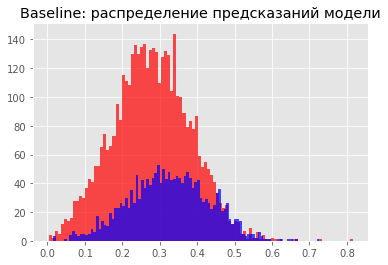

In [34]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [43]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.625


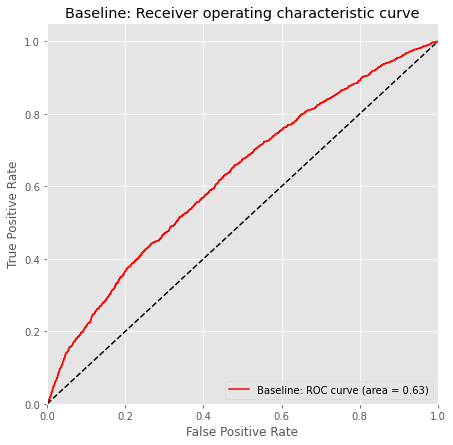

In [44]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.406


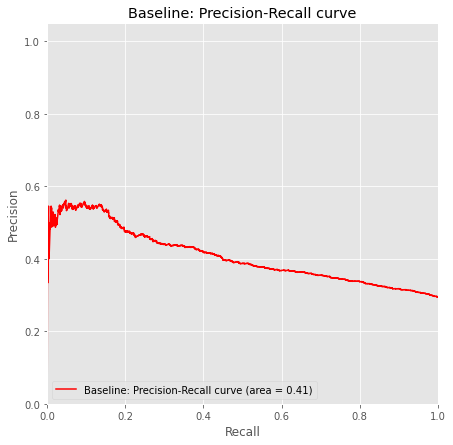

In [45]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Допустим, мы хотим построить классификатор, который будет находить не менее 80% multisim абонентов. Соответственно, имеем нижнюю границу 80% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога?

Максимальную точность при этом: 0.338
При каком пороге: 0.236


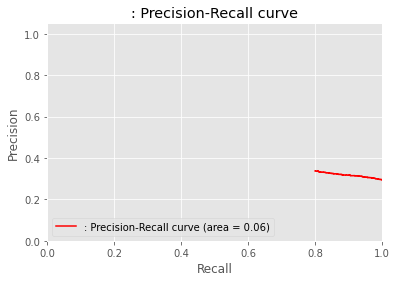

In [46]:
re80_mask = recall >= 0.8
pr_target_idx = np.arange(len(precision))[re80_mask]
pr_target = precision[re80_mask]

max_pr_idx = pr_target_idx[np.argmax(pr_target)]


print("Максимальную точность при этом: %.3f" % precision[max_pr_idx])
threshold80 = pr_thresholds[max_pr_idx]
print ("При каком пороге: %.3f" % threshold80)

plot_precision_recall_curve(recall[re80_mask], precision[re80_mask], color='r')

#### Матрица смежности

In [47]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[4261   67]
 [1717   86]]


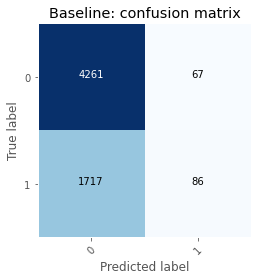

In [48]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.71      0.98      0.83      4328
           1       0.56      0.05      0.09      1803

    accuracy                           0.71      6131
   macro avg       0.64      0.52      0.46      6131
weighted avg       0.67      0.71      0.61      6131



In [51]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.71
           1 precision = 0.56
              1 recall = 0.05
   micro avg precision = 0.71 
   macro avg precision = 0.64 
weighted avg precision = 0.67 


# 2 Определение типа признаков

In [52]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [53]:
X_nunique.shape

(260,)

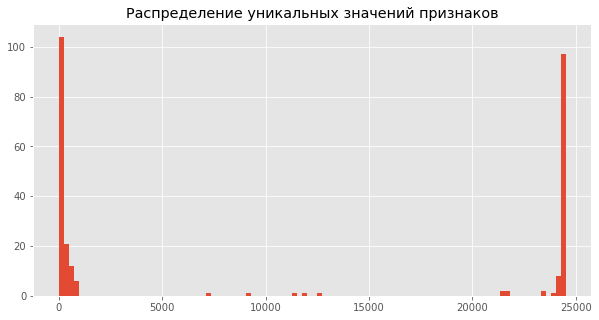

In [57]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [58]:
f_all = set(X_nunique.index.tolist())
len(f_all)

260

#### константные признаки

In [59]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

4

#### вещественные признаки

In [60]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

130

In [72]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

126

#### бинарные

In [73]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

14

In [74]:
f_other = f_other - f_binary
len(f_other)

112

#### категориальные

In [75]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

In [76]:
f_other = f_other - f_categorical
len(f_other)

86

In [77]:
f_numeric = f_numeric | f_other

In [78]:
f_other = f_other - f_numeric
len(f_other)

0

In [79]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [80]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 260

f_const: 4
f_binary: 14
f_categorical: 26
f_numeric: 216


# 3 sklearn.Pipeline

Pipeline-ы выполняют последовательность transformer-ов и могут завершаться финальным estimator-ом. Все объектов transformer-ы должны иметь два метода - fit и transform. Финальный Estimator должын иметь метод fit.

### 3.1 Column Selector

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

In [82]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [83]:
cs_pipe = Pipeline([
    ('cs', ColumnSelector(columns=['FEATURE_0', 'FEATURE_90', 'FEATURE_193', 'FEATURE_154'])),
])

In [87]:
X_test[['FEATURE_0', 'FEATURE_90', 'FEATURE_193', 'FEATURE_154']].head()

,FEATURE_0,FEATURE_90,FEATURE_193,FEATURE_154
ID,,,,
58198991,0.0,-42.455826,NaN,0.0
437075004,0.0,41.479563,NaN,1.0
345260526,0.0,-43.313025,130.395302,1.0
749150565,3.0,226.743517,1184.360325,0.0
732888674,0.0,4.720634,NaN,1.0


In [88]:
# cs_pipe.fit(X_train)

cs_pipe.transform(X_test).head()

,FEATURE_0,FEATURE_90,FEATURE_193,FEATURE_154
ID,,,,
58198991,0.0,-42.455826,NaN,0.0
437075004,0.0,41.479563,NaN,1.0
345260526,0.0,-43.313025,130.395302,1.0
749150565,3.0,226.743517,1184.360325,0.0
732888674,0.0,4.720634,NaN,1.0


### 3.2 Пайплайн обработки признаков

In [89]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [91]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [92]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['FEATURE_98', 'FEATURE_156', 'FEATURE_128',
                          'FEATURE_241', 'FEATURE_36', 'FEATURE_253',
                          'FEATURE_57', 'FEATURE_59', 'FEATURE_94', 'FEATURE_141',
                          'FEATURE_242', 'FEATURE_26', 'FEATURE_239',
                          'FEATURE_195', 'FEATURE_80', 'FEATURE_171',
                          'FEATURE_13', 'FEATURE_219', 'FEATURE_150',
                          'FEATURE_149', 'FEATURE_157', 'FEATURE_97',
                          'FEATURE_88', 'FEATURE_178', 'FEATURE_42',
                          'FEATURE_247', 'FEATURE_218', 'FEATURE_133',
                          'FEATURE_102', 'FEATURE_72', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['FEATURE_98',
                                            

In [93]:
X_test.shape[1]

260

In [94]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

357

### 3.3 Gridsearch для пайплайнов

In [95]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Про поиск имен параметров

In [98]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [99]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best roc_auc score: 0.70

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}

Grid scores on development set:

0.701 (+/-0.023) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.701 (+/-0.021) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



Сравним с baseline моделью, у которой roc_auc = 0.67 (+/- 0.02)

In [100]:
%%time
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best roc_auc score: 0.70

Best parameters set found on development set:

{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.703 (+/-0.023) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.702 (+/-0.023) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.700 (+/-0.022) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

CPU times: user 1.86 s, sys: 208 ms, total: 2.07 s
Wall time: 7.7 s


In [101]:
lg_gsc.best_params_

{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}

### 3.4 Отбор признаков в пайплайнах

In [102]:
from sklearn.feature_selection import SelectFromModel

In [112]:
from sklearn.linear_model import Lasso

Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов feature_importances_ или coef_ после выполнения метода fit.

In [124]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE), threshold=1e-5),
)

In [125]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(6131, 357)

In [126]:
%%time
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

CPU times: user 13.7 s, sys: 294 ms, total: 13.9 s
Wall time: 14 s


(6131, 274)

In [123]:
1 - 274 / 357

0.2324929971988795

Логистическая регрессия из SelectFromModel обнулила около 23% признаков.

In [127]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [128]:
%%time
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ildar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best roc_auc score: 0.70

Best parameters set found on development set:

{'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.701 (+/-0.023) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.617 (+/-0.016) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.643 (+/-0.025) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.692 (+/-0.024) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.697 (+/-0.022) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.698 (+/-0.022) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.701 (+/-0.023) for {'selectfrommodel__threshold': 1e-05}

CPU times: user 15.4 s, sys: 869 ms, total: 16.2 s
Wall time: 1min 19s


# 4 Финальная модель

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [133]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier()
)

In [134]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [135]:
%%time
param_grid = {
    "selectfrommodel__threshold": [-np.inf, 1e-05],
    
    "gradientboostingclassifier__max_depth": [1, 5],
    "gradientboostingclassifier__n_estimators": [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.71

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.654 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.654 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.698 (+/-0.012) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.698 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.695 (+/-0.007) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.695 (+

### 4.1 Сравнение моделей

In [136]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

In [137]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      4328
           1       0.61      0.26      0.37      1803

    accuracy                           0.73      6131
   macro avg       0.68      0.60      0.60      6131
weighted avg       0.71      0.73      0.69      6131



In [138]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

In [139]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      4328
           1       0.67      0.26      0.38      1803

    accuracy                           0.75      6131
   macro avg       0.71      0.60      0.61      6131
weighted avg       0.73      0.75      0.70      6131



Baseline: AUC_PR = 0.406
Baseline: AUC_ROC = 0.625
lg_fs_pred: AUC_PR = 0.510
lg_fs_pred: AUC_ROC = 0.693
gb_fs_pred: AUC_PR = 0.555
gb_fs_pred: AUC_ROC = 0.726


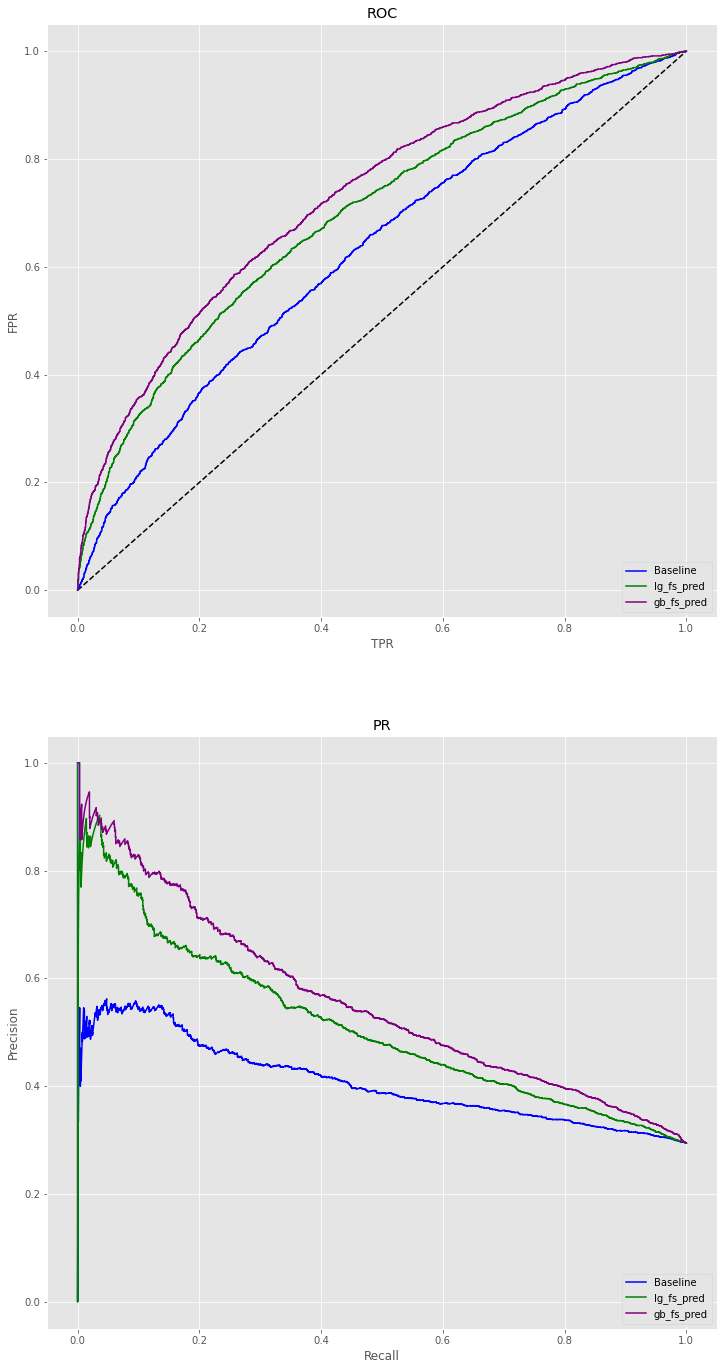

In [140]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");